In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
# from dataset import JasperRidgeDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

/home/abian/Workspace/Anaconda/envs/CLHU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import JasperRidge

dataset = JasperRidge(config.JasperRidge_PATH)
dataset_name = 'JasperRidge'
wv = np.array(dataset.wv, dtype=np.uint)

result_path = os.path.join(config.RESULTS_PATH, 'jasperRidge')

# Ground Truth

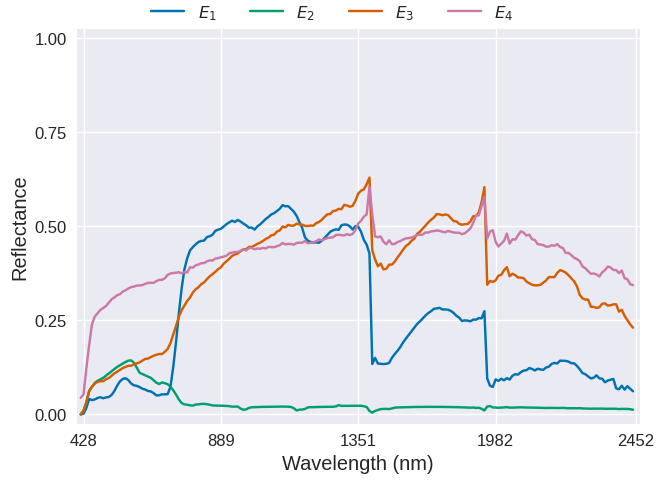

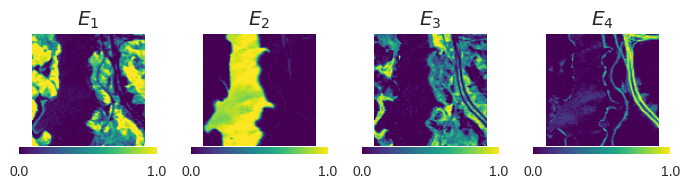

In [61]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), wv, ticks_range=(0, 1), n_ticks=5)
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [5]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

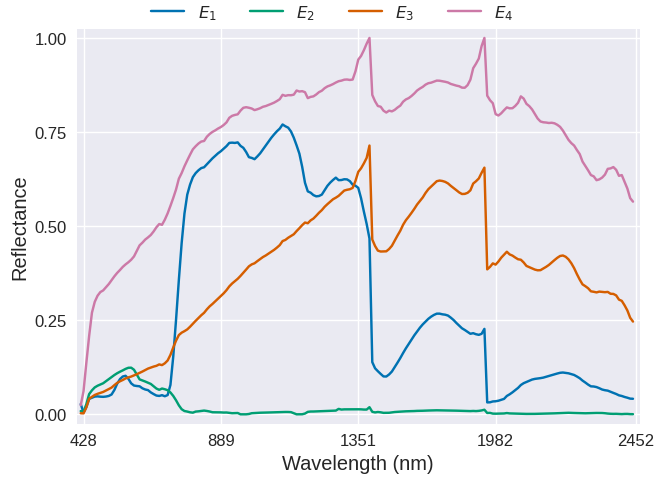

In [6]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=40, random_state=25)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)

fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

[0 1 2 3]


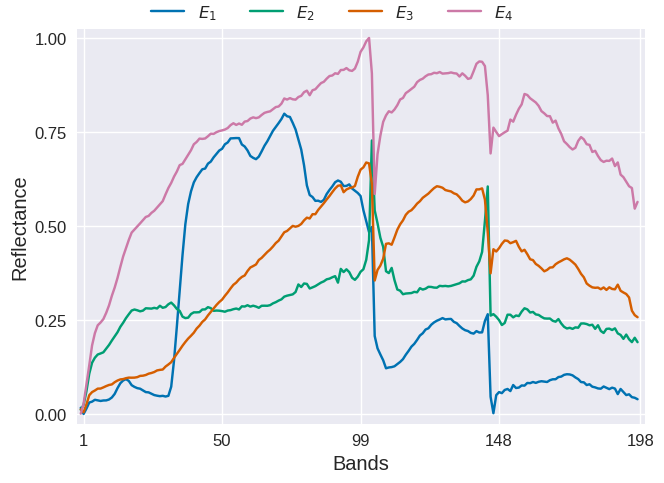

In [38]:
ee = eea.ATGP()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, sad_result = sort_endmember(endmember, dataset.endmembers())
atgp_endmember_init = endmember[e_idx]
atgp_logit_endmember_init = torch.log((atgp_endmember_init + 1e-12) / ((1-atgp_endmember_init) + 1e-12))
e_idx, _ = sort_endmember(endmember, dataset.endmembers())
print(np.unique(e_idx))

fig = plot_endmembers(atgp_endmember_init, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_atgp.pdf'), bbox_inches='tight')

In [41]:
sad_result =sad(atgp_endmember_init, dataset.endmembers())
print(np.diag(sad_result).mean())

0.32292482


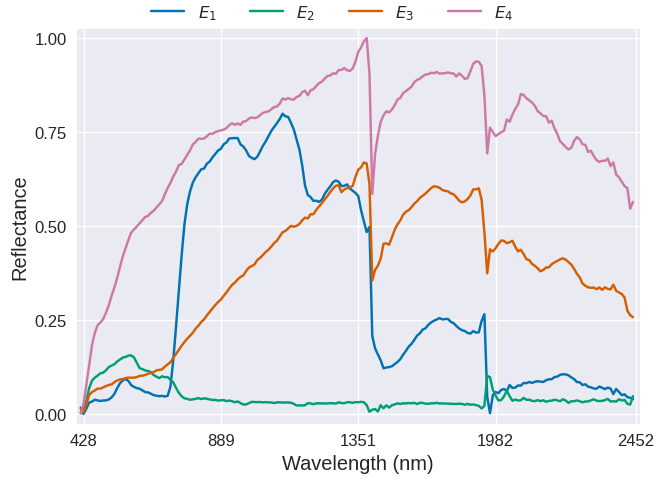

In [7]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_endmember_init = endmember[e_idx]
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

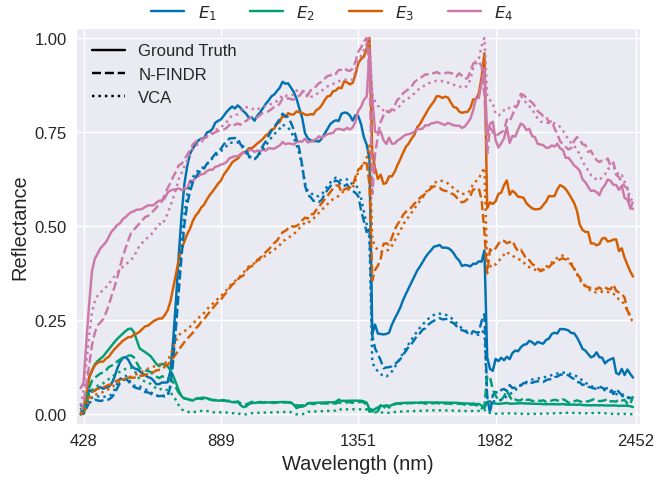

In [32]:
fig = plot_endmembers(dataset.endmembers() / dataset.endmembers().max(), wv, ticks_range=(0, 1), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/M_estimation.pdf'), bbox_inches='tight')

In [68]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

# Training

In [69]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=5e-3)

100%|██████████| 50/50 [00:19<00:00,  2.60epoch/s, tls=0.0702]


# Save model

In [22]:
# torch.save(model.state_dict(), os.path.join(result_path, 'clhu/weights/clhu.pth'))

# Testing model

In [76]:
# load model
model = ContrastiveUnmixing(dataset.n_bands, dataset.n_endmembers)

model.load_state_dict(torch.load(os.path.join(result_path, 'clhu/weights/clhu.pth')))
model = model.eval()

In [77]:
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy

criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=dataset.n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], dataset.n_endmembers)
similarity_reg = SimilarityLoss(dataset.n_endmembers, temperature=.1, reduction='mean')

In [78]:
from torch import sigmoid 
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0392) tensor(0.5127) tensor(139.4720) tensor(0.3694)


In [79]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(203.2034), tensor(0.3814))

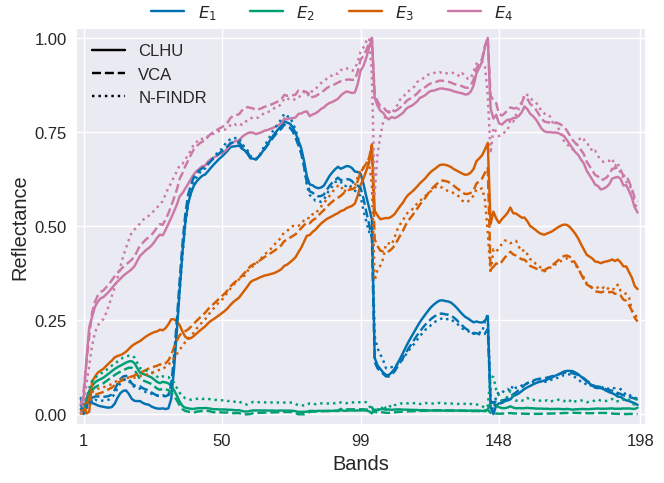

In [80]:
ebk = torch.sigmoid(model.ebk).detach().cpu()
if endmember_init_method == 'vca':
    label = 'VCA'
else:
    label = 'N-FINDR'
fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init, nfindr_endmember_init], ee_labels=['CLHU',label, 'N-FINDR'])
plt.show(fig)
fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu.pdf'), bbox_inches='tight')

# fig = plot_endmembers(ebk, ticks_range=(0, 1))
# plt.show(fig)
# fig.savefig(os.path.join(result_path, 'clhu/imgs/M_clhu_2.pdf'), bbox_inches='tight')

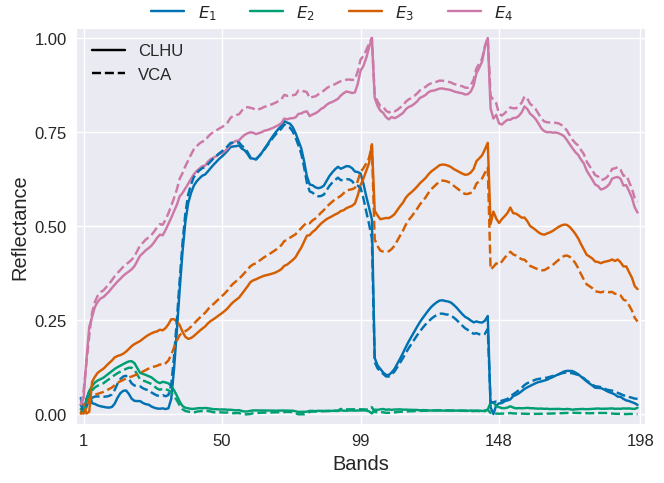

In [81]:
fig = plot_endmembers(ebk, ticks_range=(0, 1), endmember_estimation=[endmember_init], ee_labels=['CLHU',label])
plt.show(fig)


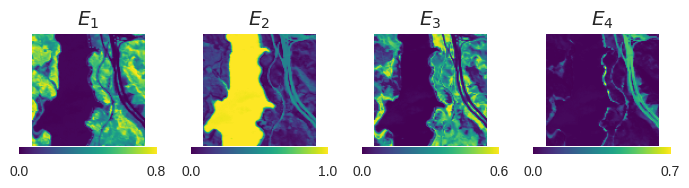

In [58]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'clhu/imgs/A_clhu_estimation.png'), dpi=300, bbox_inches='tight')

In [59]:
X_true = dataset.A @ dataset.endmembers()
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_X'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

sad_result = sad(M_hat, dataset.endmembers()).numpy()
df['SAD_M'] = np.diagonal(sad_result).mean()

df.to_csv(os.path.join(result_path, 'clhu/metrics.csv'), index=False)
df

,Method,RMSE_X,RMSE_A,SAD_M
0,CLHU,0.040614393,0.14965421,0.185494


# ...

In [18]:
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [19]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
    train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=5e-3)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

    print(rmse_x, rmse_a, sad_m)

100%|██████████| 50/50 [00:22<00:00,  2.27epoch/s, tls=0.0693]


0.04602062329649925 0.15674379467964172 0.17904805


100%|██████████| 50/50 [00:20<00:00,  2.43epoch/s, tls=0.0657]


0.042056627571582794 0.14919152855873108 0.18487164


100%|██████████| 50/50 [00:20<00:00,  2.49epoch/s, tls=0.0681]


0.04001021012663841 0.1434270143508911 0.18121405


100%|██████████| 50/50 [00:28<00:00,  1.73epoch/s, tls=0.0665]


0.043153002858161926 0.14956632256507874 0.18419631


100%|██████████| 50/50 [00:20<00:00,  2.43epoch/s, tls=0.0666]


0.04268361255526543 0.1534075289964676 0.18569036


100%|██████████| 50/50 [00:17<00:00,  2.89epoch/s, tls=0.0732]


0.04017816111445427 0.1520988643169403 0.17997567


100%|██████████| 50/50 [00:16<00:00,  3.07epoch/s, tls=0.0677]


0.04266540706157684 0.1471501737833023 0.1801806


100%|██████████| 50/50 [00:18<00:00,  2.71epoch/s, tls=0.0679]


0.043223313987255096 0.14061018824577332 0.17864293


100%|██████████| 50/50 [00:22<00:00,  2.25epoch/s, tls=0.0604]


0.045788221061229706 0.16299986839294434 0.18322925


100%|██████████| 50/50 [00:22<00:00,  2.26epoch/s, tls=0.0675]

0.043147433549165726 0.14757397770881653 0.18030068


In [21]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

(0.042892661318182944,
 0.0019686928741224703,
 0.15027692615985871,
 0.006463112856411443,
 0.18173495,
 0.0025472186971455812)

In [22]:
df.to_csv(os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method)), index=False)

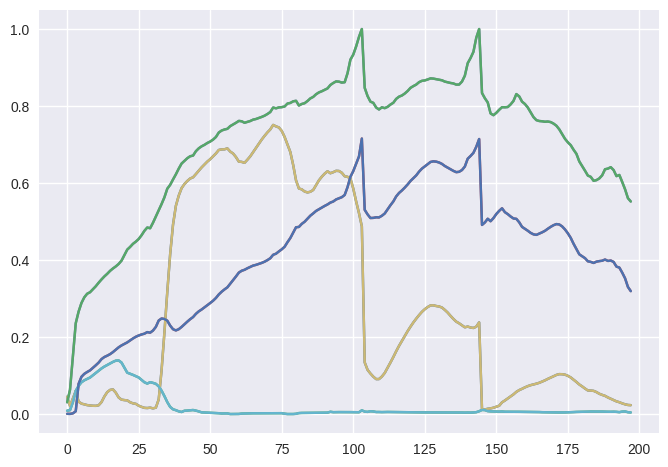

In [26]:
plt.plot(sigmoid(model.ebk).T.detach().cpu().numpy())
plt.show()